# Generating Custom Preprocessors
[The nfp package](https://github.com/NREL/nfp/blob/master/nfp/preprocessing/mol_preprocessor.py) implements a flexible approach to creating custom preprocessors through the utilization of abstract base classes.

## Generating a Preprocessor utilizes Pm values
For a dataframe with pm information, it is possible to add this value to the proprocessor as a molecule-wide property. Below is code that uses the [SmilesPreprocessor](https://github.com/NREL/nfp/blob/master/nfp/preprocessing/mol_preprocessor.py#L105) class from nfp to implement this.

In [6]:
from nfp.preprocessing import SmilesPreprocessor
from typing import Dict
from polyid import Parameters, MultiModel
import networkx as nx
import tensorflow as tf
import numpy as np
import nfp
import pandas as pd

from nfp.models.losses import masked_mean_absolute_error

from keras import layers

In [7]:
class PmPreprocessor(SmilesPreprocessor):
    # Initialize the PmPreprocessor class attributes and pass any keword args to the inherited classes

    # This function creates a graph that is used to generate the features for a molecule
    # A graph property of "pm" is set to capture stereochemistry.
    def create_nx_graph(self, row: pd.Series, **kwargs) -> nx.DiGraph:
        nx_graph = super().create_nx_graph(row.smiles_polymer)
        nx_graph.graph["pm"] = row.pm
        return nx_graph

    # This function is used to output graph properties into the preprocessor output
    def get_graph_features(self, graph_data: dict) -> Dict[str, np.ndarray]:
        return {"pm": graph_data["pm"]}

    # This function returns an output signature needed for tensor flow
    # Essentially add any inputs of your model (in this case pm) with the correct shape and dtype
    @property
    def output_signature(self) -> Dict[str, tf.TensorSpec]:
        signature = super().output_signature
        signature["pm"] = tf.TensorSpec(shape=tf.TensorShape([]), dtype="float32")
        return signature

    # similar to output_signature, add inputs of the model (pm here) with the values to pad by
    @property
    def padding_values(self) -> Dict[str, tf.constant]:
        padding_values = super().padding_values
        padding_values["pm"] = tf.constant(0, dtype=tf.float16)
        return padding_values

# Define how to featurize the input molecules
def atom_featurizer(atom):
    """ Return an string representing the atom type
    """

    return str((
        atom.GetSymbol(),
        atom.GetIsAromatic(),
        nfp.get_ring_size(atom, max_size=6),
        atom.GetDegree(),
        atom.GetTotalNumHs(includeNeighbors=True)
    ))


def bond_featurizer(bond, flipped=False):
    """ Get a similar classification of the bond type.
    Flipped indicates which 'direction' the bond edge is pointing. """
    
    if not flipped:
        atoms = "{}-{}".format(
            *tuple((bond.GetBeginAtom().GetSymbol(),
                    bond.GetEndAtom().GetSymbol())))
    else:
        atoms = "{}-{}".format(
            *tuple((bond.GetEndAtom().GetSymbol(),
                    bond.GetBeginAtom().GetSymbol())))
    
    btype = str(bond.GetBondType())
    ring = 'R{}'.format(nfp.get_ring_size(bond, max_size=6)) if bond.IsInRing() else ''
    
    return " ".join([atoms, btype, ring]).strip()

# Define Model that Accepts Pm


In [9]:
def pm_model(preprocessor, model_summary, prediction_columns, params):
    # Define the keras model
    # Input layers
    atom = layers.Input(shape=[None], dtype=tf.int64, name="atom")
    bond = layers.Input(shape=[None], dtype=tf.int64, name="bond")
    connectivity = layers.Input(shape=[None, 2], dtype=tf.int64, name="connectivity")
    global_features = layers.Input(shape=[None], dtype=tf.float32, name="pm")

    num_features = params["num_features"]  # Controls the size of the model

    # Convert from a single integer defining the atom state to a vector
    # of weights associated with that class
    atom_state = layers.Embedding(
        preprocessor.atom_classes, num_features, name="atom_embedding", mask_zero=True
    )(atom)

    # Ditto with the bond state
    bond_state = layers.Embedding(
        preprocessor.bond_classes, num_features, name="bond_embedding", mask_zero=True
    )(bond)

    # Reshape the pm input
    global_features_state = layers.Reshape((1,))(global_features)

    global_features_state = layers.Dense(
        units=params["mol_features"], name="global_features_state"
    )(global_features_state)

    # Here we use our first nfp layer. This is an attention layer that looks at
    # the atom and bond states and reduces them to a single, graph-level vector.
    # mum_heads * units has to be the same dimension as the atom / bond dimension
    global_state = nfp.GlobalUpdate(units=params["mol_features"], num_heads=1)(
        [atom_state, bond_state, connectivity, global_features_state]
    )
    global_state = layers.Add()([global_state, global_features_state])

    for _ in range(params["num_messages"]):  # Do the message passing
        new_bond_state = nfp.EdgeUpdate()(
            [atom_state, bond_state, connectivity, global_state]
        )
        bond_state = layers.Add()([bond_state, new_bond_state])

        new_atom_state = nfp.NodeUpdate()(
            [atom_state, bond_state, connectivity, global_state]
        )
        atom_state = layers.Add()([atom_state, new_atom_state])

        new_global_state = nfp.GlobalUpdate(units=params["mol_features"], num_heads=1)(
            [atom_state, bond_state, connectivity, global_state]
        )
        global_state = layers.Add()([global_state, new_global_state])

    # Get prediction layers to concat together
    prediction_layers = []
    for col in prediction_columns:
        # From polyID predicting with bond_states
        prediction_layer = layers.Dense(1, name=f"{col}_dense")(bond_state)
        prediction_layer = layers.GlobalAveragePooling1D(name=col)(prediction_layer)
        prediction_layers.append(prediction_layer)

    output = layers.Concatenate(name="predictions")(prediction_layers)

    model = tf.keras.Model([atom, bond, connectivity, global_features], output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=params["learning_rate"], decay=params["decay"]
        ),
        loss=[masked_mean_absolute_error],
    )

    if model_summary:
        print(model.summary())

    return model


# Train Model using Pm

In [10]:
# Generate model parameters
# Paremeters has default values that can be changed
params = Parameters()
params.epochs = 2

# Create the MultiModel class that manages multiple SingleModels
mm = MultiModel()

# First load data in, specifying prediction columns as well
mm.load_dataset('../data/polymer_input.csv', prediction_columns=["Tg", "Tm"])

# Split the data up into kfolds and generate the model classes
mm.split_data(kfolds=2)

# # Scale the data. This scales using the entire data set and then scales each individual model with that scaler
mm.generate_data_scaler()

# # Generate the preprocessors for each model
# Here we use a preprocessor that uses just smiles
mm.generate_preprocessors(preprocessor=PmPreprocessor, atom_features=atom_featurizer, bond_features=bond_featurizer)

# # Train the models
mm.train_models(modelbuilder=pm_model, model_params=params.to_dict())

Epoch 1/2
114/114 [==============================] - 20s 49ms/step - loss: 0.8367 - val_loss: 0.5663
Epoch 2/2
114/114 [==============================] - 2s 17ms/step - loss: 0.6903 - val_loss: 0.5883
Epoch 1/2
115/115 [==============================] - 20s 49ms/step - loss: 0.6713 - val_loss: 0.6780
Epoch 2/2
115/115 [==============================] - 2s 18ms/step - loss: 0.6015 - val_loss: 0.6795


# Look at predictions to see they vary with Pm
Without pm added there will be overlap with polymer structures due to the resolution that can be achieved of pm for a given degree of polymerization, resulting in columns of values. pm values allow for this to be countered.

The results below are not a good fit, it is just illustrative of the model.

<AxesSubplot:xlabel='pm', ylabel='Tg_pred'>

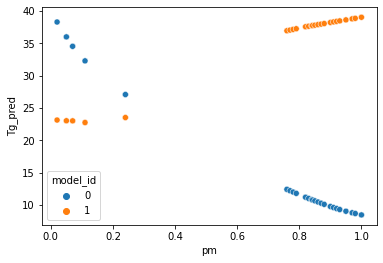

In [11]:
import seaborn as sns

# prediction_df = mm.models[0].train_df
prediction_df = mm.make_predictions(mm.df_polymer)

sns.scatterplot(data=prediction_df[prediction_df["polymer_name"] == "poly(lactic acid)"], x="pm", y="Tg_pred", hue="model_id", legend=True)